In [1]:
# BERT 모델 사용

import os
import pandas as pd
import numpy as np

from tqdm import tqdm
import tensorflow_addons as tfa
import tensorflow as tf
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, log_loss, classification_report

# Execution Environment for TFBertForSequenceClassification
# pip install tensorflow==2.7.0
# pip install transformers==4.8.0
# TensorFlow version: 2.7.0
# Transformers version: 4.8.0
print(f"TensorFlow version: {tf.__version__}")
print(f"Transformers version: {transformers.__version__}")

2023-02-27 02:57:19.841632: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-27 02:57:19.841656: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/gbike/anaconda3/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You 

TensorFlow version: 2.7.0
Transformers version: 4.8.0


In [2]:
MODEL_NAME = "bert-base-multilingual-cased"
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

2023-02-27 02:57:26.448142: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-27 02:57:26.448170: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-27 02:57:26.448188: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-255-0-134): /proc/driver/nvidia/version does not exist
2023-02-27 02:57:26.448411: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some laye

In [4]:
# 경제 뉴스 감정 데이터셋 다운로드
# 경제 뉴스 기사 내 4,846개 문장 & 감정 라벨, 0: Neutral 59.27%, 1: Positive 28.22%, 2: Negative 12.51%
# https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv
dataset = pd.read_csv("finance_data.csv")
print(dataset.head())

# 한국어 데이터 컬럼(kor_sentence)만 사용할 것이기 때문에 영문 데이터 칼럼(sentence)은 삭제
del dataset['sentence']
dataset['labels'] = dataset['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
print(dataset.head())

# 결측치 존재 여부를 확인
print(dataset.info()) # 결과 : Null 값 없음

# 중복 데이터 확인 및 중복 데이터 제거
print("BEFORE:",dataset[dataset['kor_sentence'].duplicated()]) # 중복 있음
dataset.drop_duplicates(subset = ['kor_sentence'], inplace = True) # 중복 제거
print("AFTER:",dataset[dataset['kor_sentence'].duplicated()]) # 중복 없음

dataset.to_csv("finance_data_preprocessed.csv")

     labels                                           sentence  \
0   neutral  According to Gran, the company has no plans to...   
1   neutral  Technopolis plans to develop in stages an area...   
2  negative  The international electronic industry company ...   
3  positive  With the new production plant the company woul...   
4  positive  According to the company's updated strategy fo...   

                                        kor_sentence  
0  Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로...  
1  테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...  
2  국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ...  
3  새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...  
4  2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4...  
   labels                                       kor_sentence
0       0  Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로...
1       0  테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2       2  국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ...
3       1  새로운 생산공장으로 인해 회사는 

In [5]:
# 입출력 데이터 분리
X_data = dataset['kor_sentence']
y_data = dataset['labels']

TEST_SIZE = 0.2 # Train:Test = 8:2 분리
RANDOM_STATE = 1234
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size = TEST_SIZE, 
                                                    random_state = RANDOM_STATE, 
                                                    stratify = y_data)
print(f"훈련 입력 데이터 개수: {len(X_train)}")
print(f"테스트 입력 데이터 개수: {len(X_test)}")

훈련 입력 데이터 개수: 3861
테스트 입력 데이터 개수: 966


In [6]:
# BERT 입력용 데이터 포맷으로 변경
# 입력 데이터(문장) 길이 제한
MAX_SEQ_LEN = 64

def convert_data(X_data, y_data):
    # BERT 입력으로 들어가는 token, mask, segment, target 저장용 리스트
    tokens, masks, segments, targets = [], [], [], []
    
    for X, y in tqdm(zip(X_data, y_data)):
        # token: 입력 문장 토큰화
        token = tokenizer.encode(X, truncation = True, padding = 'max_length', max_length = MAX_SEQ_LEN)
        
        # Mask: 토큰화한 문장 내 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
        num_zeros = token.count(0)
        mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros
        
        # segment: 문장 전후관계 구분: 오직 한 문장이므로 모두 0으로 초기화
        segment = [0]*MAX_SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        targets.append(y)

    # numpy array로 저장
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

# train 데이터를 Bert의 Input 타입에 맞게 변환
train_x, train_y = convert_data(X_train, y_train)

# test 데이터를 Bert의 Input 타입에 맞게 변환
test_x, test_y = convert_data(X_test, y_test)

3861it [00:01, 2952.01it/s]
966it [00:00, 3350.95it/s]


In [7]:
# BERT 기반 멀티클래스 분류 모델링
# token, mask, segment 입력 정의
token_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_word_ids')
mask_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_masks')
segment_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_segment')
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])
bert_output = bert_outputs[0]

# 하이퍼파리미터 조정
NUM_CLASS = 3 # number of softmax outputs
OPTIMIZER_NAME = 'RAdam' # Rectified Adam
LEARNING_RATE = 5e-5
TOTAL_STEPS = 10000
MIN_LR = 1e-5
WARMUP_PROPORTION = 0.1
EPSILON = 1e-8
CLIPNORM = 1.0
DROPOUT_RATE = 0.5

dropout = tf.keras.layers.Dropout(DROPOUT_RATE)(bert_output)
classification_layer = tf.keras.layers.Dense(NUM_CLASS, activation='softmax',
                                        kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02))(dropout)
bert_classification_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], classification_layer)
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LEARNING_RATE,
                                          total_steps = TOTAL_STEPS, 
                                          warmup_proportion = WARMUP_PROPORTION, 
                                          min_lr = MIN_LR, 
                                          epsilon = EPSILON,
                                          clipnorm = CLIPNORM)
bert_classification_model.compile(optimizer = optimizer, 
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                        metrics = ['accuracy'])
# If the ground truth labels are integers (e.g., 0, 1, 2, ...),
# then SparseCategoricalCrossentropy is the appropriate choice.
# On the other hand, if the ground truth labels are one-hot encoded vectors
# (e.g., [1, 0, 0], [0, 1, 0], [0, 0, 1], ...),
# then CategoricalCrossentropy can be better.

# 최고 성능의 모델 파일을 저장할 이름과 경로 설정
MODEL_DIRECTORY = './output/' # 디렉토리 미리 만들어 놓을것
BEST_MODEL_NAME = 'best_bert_model.h5'

# Early Stopping : 아래 코드의 경우 Keras로 BERT 모델(from huggingface-hub) 저장시 오류가 있어서 사용안함
'''
# patience 옵션을 5로 설정 : 모델 학습 시 성능이 개선되지 않는 횟수가 5회를 초과하면 학습을 멈춤
PATIENCE = 5
MIN_DELTA = 1e-3
early_stopping = EarlyStopping(
    monitor = "val_accuracy", 
    min_delta = MIN_DELTA,
    patience = PATIENCE)

model_checkpoint = ModelCheckpoint(
    filepath = BEST_MODEL_NAME,
    monitor = "val_loss",
    mode = "min",
    save_best_only = True, # 성능 향상 시에만 모델 저장
    verbose = 1
)
callbacks = [early_stopping, model_checkpoint]
'''

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


'\n# patience 옵션을 5로 설정 : 모델 학습 시 성능이 개선되지 않는 횟수가 5회를 초과하면 학습을 멈춤\nPATIENCE = 5\nMIN_DELTA = 1e-3\nearly_stopping = EarlyStopping(\n    monitor = "val_accuracy", \n    min_delta = MIN_DELTA,\n    patience = PATIENCE)\n\nmodel_checkpoint = ModelCheckpoint(\n    filepath = BEST_MODEL_NAME,\n    monitor = "val_loss",\n    mode = "min",\n    save_best_only = True, # 성능 향상 시에만 모델 저장\n    verbose = 1\n)\ncallbacks = [early_stopping, model_checkpoint]\n'

In [9]:
# BERT 기반 멀티클래스 분류 모델 학습
#EPOCHS = 200
EPOCHS = 1
BATCH_SZIE = 32

history = bert_classification_model.fit(train_x, train_y, 
                    epochs = EPOCHS, 
                    shuffle = True, 
                    batch_size = BATCH_SZIE, 
                    validation_data = (test_x, test_y)
                    )
'''
history = bert_classification_model.fit(train_x, train_y, 
                    epochs = EPOCHS, 
                    shuffle = True, 
                    batch_size = BATCH_SZIE, 
                    validation_data = (test_x, test_y),
                    callbacks = callbacks
                    )
'''

# 모델 저장하기 : 모델 저장 시간 약 2분 및 파일 사이즈 약 800M-Bytes
model.save_pretrained(MODEL_DIRECTORY+BEST_MODEL_NAME)

121/121 [==============================] - 511s 4s/step - loss: 1.0976 - accuracy: 0.3629 - val_loss: 1.0867 - val_accuracy: 0.5921


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


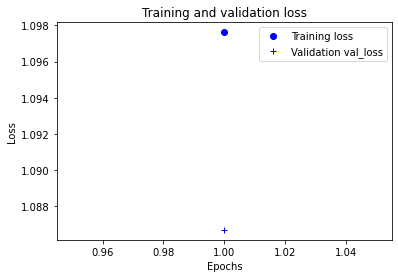

In [10]:
# training dataset = 3861, epochs = 1

import matplotlib.pyplot as plt

print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# plot training losses(x and y) using blue circle markers
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b+', label='Validation val_loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


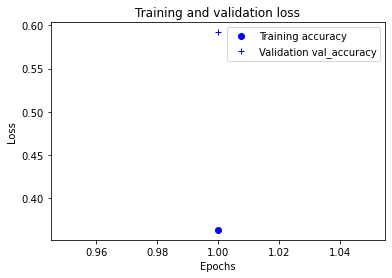

In [11]:
# training dataset = 3861, epochs = 1

import matplotlib.pyplot as plt

print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plot training losses(x and y) using blue circle markers
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b+', label='Validation val_accuracy')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [12]:
# BERT 기반 멀티클래스 분류 모델 성능 평가
loaded_best_model = TFBertForSequenceClassification.from_pretrained(MODEL_DIRECTORY+BEST_MODEL_NAME)

# 테스트 데이터셋에서 라벨 예측 결과
predicted_value = loaded_best_model.predict(test_x)
predicted_value = predicted_value.logits
print(predicted_value)
print(predicted_value.shape)

predicted_label = np.argmax(predicted_value, axis=1)
print(predicted_label)
print(predicted_label.shape)

print(test_y.shape)

# Classification Report : (In the output result)
# 0, 1, and 2 are the class labels for a multi-class classification problem.
# The precision, recall, and F1-score are calculated for each class separately
# as well as for the overall "weighted" and "macro" averages across all classes.
cl_report = classification_report(test_y, predicted_label, output_dict = True)
cl_report_df = pd.DataFrame(cl_report).transpose()
cl_report_df = cl_report_df.round(3)
print(cl_report_df)

accuracy_score_v = round(accuracy_score(y_test, predicted_label), 3) # Accuracy
precision_score_v = round(precision_score(y_test, predicted_label, average="weighted"), 3) # Precision
recall_score_v = round(recall_score(y_test, predicted_label, average="weighted"), 3) # Recall
f1_score_v = round(f1_score(y_test, predicted_label, average="weighted"), 3) # F1 Score

# 평가지표 결과 저장
METRIC_FILE = './output/best_bert_model_metric.csv'

metric_total = pd.DataFrame({
    'Base-model': MODEL_NAME,
    'Optimizer': OPTIMIZER_NAME,
    'Accuracy': accuracy_score_v,
    'Precision': precision_score_v,
    'Recall': recall_score_v,
    'F1-score': f1_score_v},
    index = ['info']
    )
metric_total.to_csv(METRIC_FILE)

Some layers from the model checkpoint at ./output/best_bert_model.h5 were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./output/best_bert_model.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


[[-9.5019054e-01 -6.9500339e-01 -5.8862306e-02]
 [-6.2214661e-01 -5.1261818e-01  1.0350091e-01]
 [-4.0326694e-01 -4.2264277e-01  2.8243446e-01]
 ...
 [-8.3282286e-01 -6.8856120e-01  1.2797518e-01]
 [-8.9856470e-01 -7.1216238e-01 -7.5391430e-04]
 [-6.2670898e-01 -3.9543453e-01  7.8468323e-02]]
(966, 3)
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2

/home/gbike/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gbike/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gbike/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gbike/anaconda3/lib/python3.

In [13]:
# BERT 기반 멀티클래스 분류 모델 성능 평가 : 모델 불러오기 시간 약 5초 걸림
loaded_best_model = TFBertForSequenceClassification.from_pretrained(MODEL_DIRECTORY+BEST_MODEL_NAME)

ground_truth = ['NULL'] # 라벨값 넣으면됨 (사용안함)
input_samples = ['지쿠터 타고갈까']

# 샘플 데이터를 BERT 입력용 데이터 포맷으로 변경
bert_input_samples, bert_label_samples = convert_data(input_samples, ground_truth)
print(bert_input_samples)
print(bert_label_samples)

# 샘플 데이터에서 라벨 예측 결과
predicted_value = loaded_best_model.predict(bert_input_samples)
predicted_label = np.argmax(predicted_value.logits, axis=1)

print(predicted_value.logits)
print(predicted_label)

if np.argmax(predicted_label) == 2 :
    print("2번 타입 문장")
elif np.argmax(predicted_label) == 1 :
    print("1번 타입 문장")
elif np.argmax(predicted_label) == 0 :
    print("0번 타입 문장")

Some layers from the model checkpoint at ./output/best_bert_model.h5 were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./output/best_bert_model.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
1it [00:00, 2033.11it/s]

[array([[   101,   9706,  61156,  21876,   9845,  11664, 101202, 118671,
           102,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0]]), array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[[-0.30371767 -0.40333408  0.23069347]]
[2]
0번 타입 문장
